In [1]:
import pandas as pd
import numpy as np

from PIL import Image
import os, sys
import cv2

import matplotlib.pyplot as plt

import random
import warnings
from concurrent import futures

from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import nevergrad as ng

from imblearn.combine import SMOTETomek

## Contenidos

<div class="alert alert-block alert-info" style="margin-top: 20px">

1.  [**Descripción del Proyecto**](#0)<br>
2.  [**Importación de Imágenes**](#2)<br>
2.  [**Visualización de Imágenes**](#4)<br>
3.  [**Ajuste y Equilibrado de los Datos**](#6) <br>
4.  [**Primer Ajuste de HiperParámetros**](#8) <br>
2.  [**Primer Entrenamiento**](#10) <br>
2.  [**Ajuste de Parámetros para el mejor modelo**](#12) <br>
3.  [**Entrenamiento**](#14)
3.  [**Predicción**](#16)
3.  [**Demostración con algunos ejemplos**](#18)

</div>

### **Descripción del Proyecto** <a id="0"></a>


El proyecto consiste en desarrollar un algoritmo de Machine Learning.
<br>A partir de una imagen de un tumor de Cervix, se asigna el tipo de tratamiento que mejor funcionaría en cada caso, atendiendo a esta imagen que explica más detalladamente la clasificación.

<img src=https://storage.googleapis.com/kaggle-competitions/kaggle/6243/media/Screen%20Shot%202017-03-09%20at%205.20.01%20PM.png width="600" height="337"> 

Este proyecto se basa en una competición de Kaggle lanzada por Intel y MobileODT. <br>
Visitar <a href="https://www.kaggle.com/competitions/intel-mobileodt-cervical-cancer-screening/overview">Kaggle</a> para mas información.

### **Importación de Imágenes** <a id="2"></a>

Se importan las imagenes de los tres tipos que están guardadas en sus respectivos tres ficheros. <br>
En la función preprocess primero se importan las imagenes; se reescalan usando openCV; tras esto, se recortan para eliminar los bordes, ya que no son determinantes en relación a la clasificación; se transforman a niveles de gris; también se aplica una máscara de convolución laplaciana, para dejar las partes significativas de la imagen en color blanco y las zonas del fondo en negro; por último se ecualiza el histograma para obtener mejores resultados.

In [2]:
x_data = []

# Máscara de convolución

mLap = np.array([[-1,-1,-1],
                [-1,8,-1],
                [-1,-1,-1]])

def preprocess(path, data):
    dirs = os.listdir( path )
    for item in dirs:
        if os.path.isfile(path+item):
            
            # Lee las imágenes del directorio
            im = cv2.imread(path+item, cv2.IMREAD_UNCHANGED)
            f, e = os.path.splitext(path+item)

            # Define el tamaño de la imagen.
            width = 300
            height = 300
            dim = (width, height)
            im_resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)

            # Recorta la imagen
            im_cropped = im_resized[50:250, 50:250]

            # Transforma a niveles de gris
            im_gray = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2GRAY)
            # Aplica la máscara
            res = cv2.filter2D (im_gray, -1, mLap)
            # Ecualiza el histograma
            eq = cv2.equalizeHist(res)
            
            # Guarda la imagen final en la lista
            data.append(eq)

# Aplica el preprocesamiento a cada clase y crear su respesctiva 'y' para introducirlo en un dataframe

preprocess("Data/train/Type_1/", x_data)
y_type1 = np.ones((len(x_data),), dtype=int)

preprocess("Data/train/Type_2/", x_data)
y_type2 = np.full(len(x_data)-len(y_type1), 2)

preprocess("Data/train/Type_3/", x_data)
y_type3 = np.full(len(x_data)-len(y_type1)-len(y_type2), 3)

y_data = np.concatenate((y_type1, y_type2, y_type3), axis = 0)

### **Visualización de imagenes** <a id="4"></a>

Se visualizan algunas imágenes de ejemplo para que poder apreciar el preprocesamiento aplicado.

(<matplotlib.image.AxesImage at 0x1b3292a11e0>, (-0.5, 199.5, 199.5, -0.5))

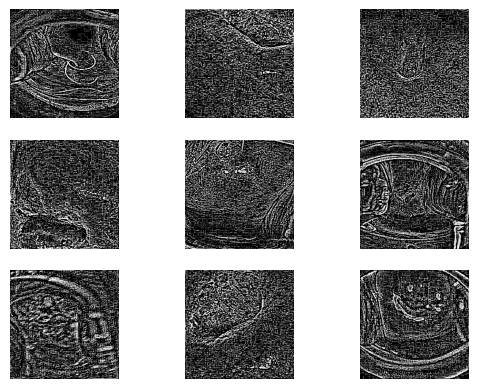

In [4]:
u1 = random.choice(x_data)
u2 = random.choice(x_data)
u3 = random.choice(x_data)
u4 = random.choice(x_data)
u5 = random.choice(x_data)
u6 = random.choice(x_data)
u7 = random.choice(x_data)
u8 = random.choice(x_data)
u9 = random.choice(x_data)

plt.subplot(331)
plt.imshow(u1, "gray"), plt.axis("off")
plt.subplot(332)
plt.imshow(u2, "gray"), plt.axis("off")
plt.subplot(333)
plt.imshow(u3, "gray"), plt.axis("off")
plt.subplot(334)
plt.imshow(u4, "gray"), plt.axis("off")
plt.subplot(335)
plt.imshow(u5, "gray"), plt.axis("off")
plt.subplot(336)
plt.imshow(u6, "gray"), plt.axis("off")
plt.subplot(337)
plt.imshow(u7, "gray"), plt.axis("off")
plt.subplot(338)
plt.imshow(u8, "gray"), plt.axis("off")
plt.subplot(339)
plt.imshow(u9, "gray"), plt.axis("off")

### **Ajuste y Equilibrado de los Datos** <a id="6"></a>

Se aplanan las imagenes para poder usar los datos en el entrenamiento. Se pasa de tener (1481, 10, 10) 1481 filas, con una matriz de 200x200 cada una, a (1481, 100) 1481 filas, cada una con un array de 100 elementos. <br>
Los clasificadores a utilizar no aceptan matrices como argumentos, por lo que "aplanamos" las imagenes y las tratamos como si fuesen vectores de una dimensión. <br>


In [3]:
# Aplana las imágenes

x_numpy = np.array(x_data)
x_numpy = x_numpy.reshape(x_numpy.shape[0], (x_numpy.shape[1]*x_numpy.shape[2]))

# Crea el dataframe

df = pd.DataFrame(x_numpy)

# Introduce la columna del tipo.

series = pd.Series(y_data)
df["Tipo"] = series

Se separa la variable objetivo de los datos.

In [4]:
Y_train = df.iloc[:, -1]
X_train = df.iloc[:,:-1]

Se ve la cantidad de datos que hay de cada tipo para poder equilibrarlos.

Tipo 1: 250
Tipo 2: 781
Tipo 3: 450
Proportion: 3:2 1.74 : 1
Proportion: 2:1 3.12 : 1
Proportion: 3:1 1.8 : 1


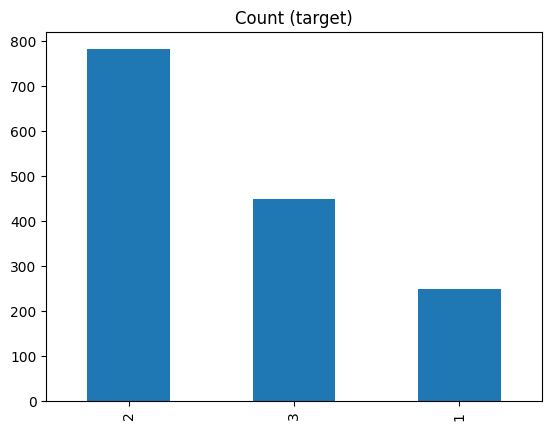

In [6]:
target_count = Y_train.value_counts()
print('Tipo 1:', target_count[1])
print('Tipo 2:', target_count[2])
print('Tipo 3:', target_count[3])
print('Proportion: 3:2', round(target_count[2] / target_count[3], 2), ': 1')
print('Proportion: 2:1', round(target_count[2] / target_count[1], 2), ': 1')
print('Proportion: 3:1', round(target_count[3] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

SMOTE-Tomek es un método de remuestreo que combina el método SMOTE (Synthetic Minority Over-sampling Technique) y Tomek Links para tratar el desbalance de clases en un conjunto de datos. SMOTE genera nuevas muestras sintéticas en el espacio de características para la clase minoritaria, mientras que Tomek Links elimina aquellas muestras de la clase mayoritaria que están más cerca de las muestras de la clase minoritaria.

Al hacer pruebas con el desbalanceamiento de los datos, se observa que, el modelo tiene un mejor desempeño si se dejan las clases con su desbalanceamiento original pero de una manera más leve. Aun que sobre el papel, el modelo debería aprender mejor si todas las clases estan balanceadas (ya que no debería clasificar las clases por su probabilidad a pertenecer a una u otra), desde mi punto de vista, dejar las clases algo desbalanceadas respetando las posiciones originales, puede ayudar al modelo, siendo esto un atributo más para realizar la clasificación.

Tipo 1: 650
Tipo 2: 799
Tipo 3: 699
Proportion: 2:3 1.14 : 1
Proportion: 2:1 1.23 : 1
Proportion: 1:3 0.93 : 1


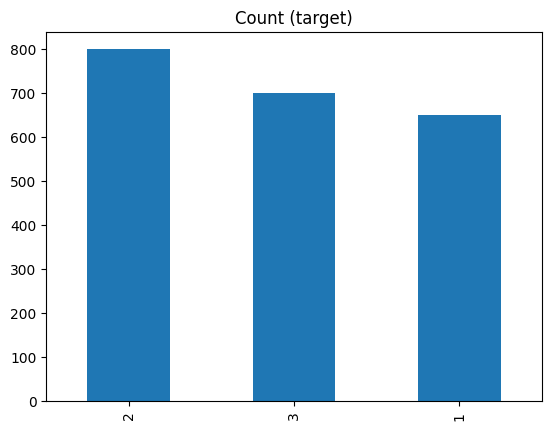

In [5]:
warnings.filterwarnings('ignore')

ratio={1:650, 2:800, 3:700}

smote_tomek = SMOTETomek(sampling_strategy=ratio, random_state=42)

X_st, y_st = smote_tomek.fit_resample(X_train, Y_train)

target_count = pd.Series(y_st).value_counts()
print('Tipo 1:', target_count[1])
print('Tipo 2:', target_count[2])
print('Tipo 3:', target_count[3])
print('Proportion: 2:3', round(target_count[2] / target_count[3], 2), ': 1')
print('Proportion: 2:1', round(target_count[2] / target_count[1], 2), ': 1')
print('Proportion: 1:3', round(target_count[1] / target_count[3], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

### **Primer Ajuste de HiperParámetros** <a id="8"></a>

Se hace un primer ajuste de HiperParámetros para tener una aproximación más o menos buena en el momento del primer entrenamiento, para poder sacar unas conclusiones más parecidas al modelo final. <br>
Se optimizan los claficadores KNN y RandomForest ya que son los que van a estar más presentes en el entrenamiento.

En el ajuste de parametros exhaustivo se explican los tipos de búsqueda de parámetros.

In [11]:
# Define los parámetros y sus posibles valores para la búsqueda de parámetros

param_grid_rForest = {
    'bootstrap': [True, False], # Utilizar o no bootstrap para el muestreo de entrenamiento
    'max_depth': [None, 10, 20, 30, 40, 50, 100, 200, 500], # Profundidad máxima de los árboles
    'max_features': ["sqrt", "log2", None], # Número de características a considerar al dividir un nodo
    'min_samples_leaf': [1, 2, 5, 10], # Número mínimo de muestras para estar en un nodo hoja
    'min_samples_split': [2, 5, 10], # Número mínimo de muestras para dividir un nodo
    'criterion': ["gini", "entropy", "log_loss"], # Criterio de impureza utilizado para dividir los nodos
    'n_estimators': [int(x) for x in np.linspace(10, 1000, num=100)] # Número de árboles en el bosque
}

# Usa RandomizedSearchCV para buscar los mejores parametros

rForest_grid = RandomizedSearchCV(
    estimator=RandomForestClassifier(), param_distributions = param_grid_rForest, n_iter=20, cv=5, n_jobs=-1, verbose=2)

rForest_grid.fit(X_st, y_st)
rForest_grid.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'n_estimators': 180,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'gini',
 'bootstrap': False}

In [17]:
# Define los parámetros y sus posibles valores para la búsqueda de parámetros

param_grid_KNN = {
    'n_neighbors': [int(x) for x in np.linspace(1, 100, num=50)], # Número de vecinos a considerar
    'leaf_size': [int(x) for x in np.linspace(1, 100, num=50)], # Tamaño de las hojas del árbol de búsqueda
    'p': [1,2], # Parámetro de la distancia (1 para distancia manhattan, 2 para distancia euclidiana)
}

# Usa RandomizedSearchCV para buscar los mejores parametros

KNN_grid = GridSearchCV(
    estimator=KNeighborsClassifier(), param_grid = param_grid_KNN, cv=5, n_jobs=-1, verbose=2)

KNN_grid.fit(X_st, y_st)
KNN_grid.best_params_

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


{'leaf_size': 1, 'n_neighbors': 1, 'p': 1}

### **Primer Entrenamiento** <a id="10"></a>

Se realiza un primer entrenamiento para ver cuáles son los clasificadores que mejor funcionan con estos datos. Para poder optimizar exhaustivamente sus parámetros y usarlos en el apartado del entrenamiento. <br>
También se usa como medida f1 y como método de entrenamiento cross_validation.

##### F1

En este caso se usa como medida **f1_macro**<br>

F1 es una medida de rendimiento utilizada en problemas de clasificación para evaluar la precisión y la exhaustividad (o recall) de un modelo. El puntaje F1 se calcula como la media armónica entre la precisión y el recall, y se define como:<br>

F1 = 2 * (precisión * recall) / (precisión + recall)<br>

La precisión se refiere a la fracción de resultados positivos correctos entre todos los resultados positivos, mientras que el recall se refiere a la fracción de resultados positivos correctos entre todos los casos positivos verdaderos.<br>

El puntaje F1 es una medida útil cuando se busca un equilibrio entre precisión y recall, ya que tiene en cuenta tanto el número de verdaderos positivos como el número de falsos positivos. Sin embargo, también es importante tener en cuenta que F1 puede ser una medida engañosa si hay desequilibrio en la clase, es decir, si hay una gran diferencia en la cantidad de ejemplos entre las diferentes clases.<br>

En este caso 'f1_macro' calcula el promedio del puntaje F1 para cada clase.

#### Cross Validation

La validación cruzada (cross validation) es un método utilizado para evaluar el rendimiento de un modelo de aprendizaje automático. Consiste en dividir los datos de entrada en grupos, llamados "fold", y entrenar el modelo en diferentes combinaciones de esos grupos mientras se evalúa en uno de ellos. El proceso se repite varias veces con diferentes combinaciones de entrenamiento y pruebas para obtener una estimación más precisa del rendimiento del modelo. <br>

La ventaja de utilizar la validación cruzada es que permite obtener una estimación más precisa del rendimiento del modelo, ya que se utilizan varias combinaciones de datos para entrenar y evaluar el modelo. Además, permite detectar si el modelo está sobreajustando los datos de entrenamiento.

In [32]:
warnings.filterwarnings('ignore')

# Define todos los clasificadores para compararlos

rf = RandomForestClassifier(n_estimators = 180,
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'sqrt',
                            max_depth = 30,
                            criterion = 'gini',
                            bootstrap = False,
                            random_state=42,
                            n_jobs=-1)

knn = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)
svc = SVC(kernel='rbf', probability=True, random_state=42)
sclf_pass_false = StackingClassifier(estimators=[('rf', rf), ('knn', knn)], passthrough=False, n_jobs = -1)
sclf_pass_true = StackingClassifier(estimators=[('rf', rf), ('knn', knn)], passthrough=True, stack_method= 'auto', n_jobs = -1)
vc = VotingClassifier(estimators=[('rf', rf), ('knn', knn), ('st', sclf_pass_false)], n_jobs = -1)
bag = BaggingClassifier(rf, n_estimators=10, max_samples=0.05, random_state=42, n_jobs = -1)
adaboost = AdaBoostClassifier(n_estimators=10, random_state=42)
gb = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, criterion='mse', max_depth=1, random_state=42)

# Crea el contenido del dataframe con los clasificadores y el resultado del entrenamiento.

regs = {
    "RandomForest": rf,
    "KNN": knn,
    "VotingClassifier": vc,
    "BaggingClassifier": bag,
    "AdaBoostClassifier": adaboost,
    "GradientBoosting": gb,
    "Stacking_con_passthrough": sclf_pass_true,
    "Stacking_sin_passthrough": sclf_pass_false    
}

scores1 = {
    "F1": []
}

# Entrena cada clasificador y guarda su puntuación

for reg in regs.values():
    reg.fit(X_st, y_st)
    score1 = np.mean(cross_val_score(reg, X_st, y_st, cv=5, scoring='f1_macro', n_jobs=-1))
    scores1["F1"].append(score1)

# Crea el dataframe con los datos obtenidos y lo muestra

scores1 = pd.DataFrame(scores1, index=regs.keys()).sort_values(by=['F1'], ascending=False)


scores1

,F1
Stacking_con_passthrough,0.796667
Stacking_sin_passthrough,0.763230
VotingClassifier,0.757420
RandomForest,0.621472
GradientBoosting,0.517254
KNN,0.489022
AdaBoostClassifier,0.488083
BaggingClassifier,0.459752


### **Ajuste Parámetros para el mejor modelo** <a id="12"></a>

Se optimizan los parámetros para el mejor modelo no perteneciente a ensembles ya que luego estos ensembles se compondrán de los modelos optimizados. <br>
Lo óptimo seria optimizar a la vez los clasificadores dentro de un Stacking, pero se necesita una capacidad de cómputo muy grande. <br>
Los mejores modelos que no pertenecen a ensembles son RandomForest, GradientBoosting y KNN por lo que se optimizan los parametros para RandomForest y GradientBoosting ya que para KNN al no necesitar tanta capacidad de cómputo se optimizaron en el apartado de "[**Primer Ajuste de HiperParámetros**](#12)" con GridSearch.

**GridSearchCV** se utiliza para hacer búsqueda exhaustiva de parámetros, es decir, se evalúa el modelo con todas las posibles combinaciones de parámetros y selecciona la combinación que proporciona el mejor rendimiento. <br>
**RandomSearchCV** es como GridSearchCV pero en vez de evaluar todos los parámetros, elige combinaciones aleatorias para reducir el coste computacional. <br>
**Nevergrad** utiliza un enfoque de optimización basado en gradientes para encontrar los parámetros óptimos de un modelo. Primero, se especifica un objetivo a optimizar (como minimizar el error de un modelo) y luego se proporcionan los parámetros a optimizar. Nevergrad utiliza un algoritmo de optimización para ajustar iterativamente los parámetros de modo que se maximice o se minimice el objetivo especificado. Adicionalmente se puede modificar la variable de budget, para especificar el coste que se requiere para la optimización.<br><br>Por lo que a la hora de obtener el mejor resultado para la optimización de muchos parámetros y la capacidad de cómputo disponible la mejor opción es Nevergrad. 


In [8]:
test_scores = []

# Define una función de optimización para encontrar los mejores parámetros de Random Forest

def opt_rfc(n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, class_weight, X=X_st, y=y_st):

  # Utiliza un objeto KFold para dividir los datos en 5 conjuntos de validación cruzada

  cv = KFold(n_splits=5, shuffle=True, random_state=42)

  # Crea una instancia del clasificador RandomForestClassifier con los parámetros especificados

  model = RandomForestClassifier(
    n_estimators=n_estimators, 
    criterion=criterion, 
    max_depth=max_depth,
    min_samples_split=min_samples_split, 
    min_samples_leaf=min_samples_leaf, 
    class_weight=class_weight, 
    random_state=22,
    n_jobs=-1
  )

  # Utiliza cross_validate para calcular la puntuación f1_macro para cada uno de los 5 conjuntos de validación cruzada

  scores = cross_validate(model, X, y, cv=cv, scoring=('f1_macro'))
  f1 = np.mean(scores["test_score"])
  # Imprime los parámetros y la puntuación f1 obtenida
  print(
    f"n_estimators: {n_estimators}, criterion: {criterion}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, class_weight: {class_weight}, f1: {f1}"
  )
  # Agrega la puntuación f1 a la lista de puntuaciones de prueba
  test_scores.append(f1)

  # Devuelve el valor negativo de la puntuación f1 para minimizar
  return -f1

# Define los parámetros a optimizar

n_estimators = ng.p.TransitionChoice(range(10, 1000, 100)) # número de árboles en el bosque
criterion = ng.p.Choice(["gini", "entropy"]) # criterio de impureza para dividir los nodos
max_depth = ng.p.Choice(range(1, 500, 50)) # profundidad máxima de los árboles
min_samples_split = ng.p.TransitionChoice(range(2, 10, 1)) # número mínimo de muestras necesarias para dividir un nodo
min_samples_leaf = ng.p.TransitionChoice(range(1, 10, 1)) # número mínimo de muestras en un nodo hoja
class_weight = ng.p.Choice(["balanced", "balanced_subsample"]) # pesos para cada clase

# Crea una instancia de Instrumentation para pasar los parámetros a optimizar al optimizador
params = ng.p.Instrumentation(n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, class_weight)

# Crea una instancia del optimizador TwoPointsDE de Nevergrad con un presupuesto de 500 iteraciones
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=500)

# Utiliza un ThreadPoolExecutor para ejecutar el proceso de optimización
with futures.ThreadPoolExecutor(max_workers=optimizer.num_workers) as executor:
  best = optimizer.minimize(opt_rfc, batch_mode=False, executor=executor)  

# Imprime el mejor valor obtenido
best.value

n_estimators: 810, criterion: gini, max_depth: 351, min_samples_split: 4, min_samples_leaf: 5, class_weight: balanced, f1: 0.6787056292244444
n_estimators: 710, criterion: entropy, max_depth: 201, min_samples_split: 2, min_samples_leaf: 5, class_weight: balanced_subsample, f1: 0.6780419895503182
n_estimators: 110, criterion: gini, max_depth: 351, min_samples_split: 7, min_samples_leaf: 4, class_weight: balanced, f1: 0.6805066915184488
n_estimators: 310, criterion: entropy, max_depth: 201, min_samples_split: 5, min_samples_leaf: 2, class_weight: balanced_subsample, f1: 0.6785730799196521
n_estimators: 610, criterion: entropy, max_depth: 1, min_samples_split: 7, min_samples_leaf: 9, class_weight: balanced_subsample, f1: 0.4392976062423172
n_estimators: 410, criterion: gini, max_depth: 351, min_samples_split: 7, min_samples_leaf: 4, class_weight: balanced, f1: 0.679361658682146
n_estimators: 610, criterion: entropy, max_depth: 201, min_samples_split: 9, min_samples_leaf: 4, class_weight: 

c:\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


n_estimators: 910, criterion: entropy, max_depth: 101, min_samples_split: 2, min_samples_leaf: 1, class_weight: balanced, f1: 0.6856753771939792
n_estimators: 810, criterion: gini, max_depth: 51, min_samples_split: 5, min_samples_leaf: 2, class_weight: balanced, f1: 0.6825095278082799
n_estimators: 910, criterion: gini, max_depth: 401, min_samples_split: 2, min_samples_leaf: 1, class_weight: balanced_subsample, f1: 0.6809992025859857
n_estimators: 810, criterion: entropy, max_depth: 251, min_samples_split: 5, min_samples_leaf: 1, class_weight: balanced, f1: 0.6849439579340417
n_estimators: 810, criterion: entropy, max_depth: 401, min_samples_split: 2, min_samples_leaf: 1, class_weight: balanced_subsample, f1: 0.683184776689902
n_estimators: 110, criterion: gini, max_depth: 101, min_samples_split: 2, min_samples_leaf: 2, class_weight: balanced, f1: 0.6781033611137083
n_estimators: 610, criterion: entropy, max_depth: 301, min_samples_split: 2, min_samples_leaf: 1, class_weight: balanced_

((710, 'gini', 51, 2, 1, 'balanced'), {})

In [38]:
warnings.filterwarnings('ignore')

test_scores1 = []

# Define una función de optimización para encontrar los mejores parámetros de Gradient Boosting

def opt_rfc1(learning_rate, n_estimators, subsample, criterion, min_samples_split, min_samples_leaf, max_depth, max_features, X=X_st, y=y_st):

  # Utiliza un objeto KFold para dividir los datos en 5 conjuntos de validación cruzada
  
  cv = KFold(n_splits=5, shuffle=True, random_state=42)

  # Crea una instancia del clasificador GradientBoostingClassifier con los parámetros especificados

  model1 = GradientBoostingClassifier(
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    subsample = subsample,
    criterion = criterion,
    min_samples_split = min_samples_split,
    min_samples_leaf = min_samples_leaf,
    max_depth = max_depth,
    max_features = max_features,
    random_state=22
  )

  # Utiliza cross_validate para calcular la puntuación f1_macro para cada uno de los 5 conjuntos de validación cruzada
  
  scores1 = cross_validate(model1, X, y, cv=cv, scoring=('f1_macro'))
  f1 = np.mean(scores1["test_score"])
  
  # Imprime los parámetros y la puntuación f1 obtenida
  print(
    f"learning_rate: {learning_rate}, n_estimators: {n_estimators}, subsample: {subsample}, criterion: {criterion}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, max_depth: {max_depth}, max_features: {max_features}, f1: {f1}"
  )
  # Agrega la puntuación f1 a la lista de puntuaciones de prueba
  test_scores1.append(f1)

  # Devuelve el valor negativo de la puntuación f1 para minimizar
  return -f1

# Define los parámetros a optimizar

learning_rate = ng.p.Choice([0.0001,0.001, 0.01, 0.1]) # ratio de aprendizaje
n_estimators = ng.p.TransitionChoice(range(50,551,50)) # Numero de estimadores para usar en el modelo
subsample = ng.p.TransitionChoice([i/10.0 for i in range(1,11)]) # Porcentaje de muestras a utilizar en cada iteracion
criterion = ng.p.Choice(["friedman_mse", "squared_error"]) # Criterio para medir la calidad de la separacion
min_samples_split = ng.p.TransitionChoice([i/10.0 for i in range(1,11)]) # Proporcion minima de muestras para dividir un nodo
min_samples_leaf = ng.p.TransitionChoice([i/10.0 for i in range(1,11)]) # Proporcion minima de muestras en un nodo hoja
max_depth = ng.p.TransitionChoice(range(1,21,1)) # Profundidad maxima del arbol
max_features = ng.p.Choice(["auto", "sqrt", "log2"]) # Numero de caracteristicas a considerar en cada division

# Crea una instancia de Instrumentation para pasar los parámetros a optimizar al optimizador
params1 = ng.p.Instrumentation(learning_rate, n_estimators, subsample, criterion, min_samples_split, min_samples_leaf, max_depth, max_features)

# Crea una instancia del optimizador TwoPointsDE de Nevergrad con un presupuesto de 500 iteraciones
optimizer1 = ng.optimizers.TwoPointsDE(parametrization=params1, budget=500)

# Utiliza un ThreadPoolExecutor para ejecutar el proceso de optimización
with futures.ThreadPoolExecutor(max_workers=optimizer.num_workers) as executor:
  best = optimizer1.minimize(opt_rfc1, batch_mode=False, executor=executor)  

# Imprime el mejor valor obtenido
best.value

learning_rate: 0.1, n_estimators: 450, subsample: 0.4, criterion: squared_error, min_samples_split: 0.5, min_samples_leaf: 0.2, max_depth: 2, max_features: sqrt, f1: 0.18068565500152922
learning_rate: 0.1, n_estimators: 200, subsample: 0.1, criterion: friedman_mse, min_samples_split: 0.6, min_samples_leaf: 0.2, max_depth: 13, max_features: log2, f1: 0.18068565500152922
learning_rate: 0.0001, n_estimators: 550, subsample: 0.9, criterion: squared_error, min_samples_split: 0.3, min_samples_leaf: 0.9, max_depth: 16, max_features: sqrt, f1: 0.18068565500152922
learning_rate: 0.1, n_estimators: 50, subsample: 0.6, criterion: squared_error, min_samples_split: 0.3, min_samples_leaf: 0.4, max_depth: 11, max_features: auto, f1: 0.18068565500152922
learning_rate: 0.001, n_estimators: 250, subsample: 1.0, criterion: friedman_mse, min_samples_split: 1.0, min_samples_leaf: 0.7, max_depth: 9, max_features: log2, f1: 0.18068565500152922
learning_rate: 0.001, n_estimators: 150, subsample: 0.8, criterio

### **Entrenamiento** <a id="14"></a>

Una vez decididos cuales son los mejores parámetros para cada modelo y cuál es el modelo que mejor clasifica las imágenes, se usa en el entrenamiento.

En cuanto a los dos StackingClassifier, con el argumento passthrough=False, combina los resultados de cada modelo utilizando un modelo adicional. El modelo con argumento passthrough=True simplemente pasa los resultados de cada modelo.

Aun que GradientBoosting tiene mejores resultados que Knn en el primer entrenamiento, al usar StackingClassifier junto a randomForest, los resultados son peores que al usar Knn, ademas, Knn es mucho más rápido. <br>
Al entrenar el stacking con GradientBoosting se obtuvo un f1 de 0.772826.

Se introduce k-fold, donde los datos se dividen en k grupos y se entrena el modelo k veces, cada vez usando un grupo diferente como conjunto de pruebas y los k-1 grupos restantes se utilizan como conjunto de entrenamiento.

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define los clasificadores para el Stacking

rf = RandomForestClassifier(n_estimators = 710,
                            criterion = 'gini',
                            max_depth = 51,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            class_weight = 'balanced',
                            random_state=42,
                            n_jobs=-1)

knn = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)

# Define el Stacking con passthrough = True

sclf_pass_true = StackingClassifier(estimators=[('rf', rf), ('knn', knn)], passthrough=True, n_jobs = -1)

# Crea el contenido del dataframe con los clasificadores y el resultado del entrenamiento.

regs = {
    "Stacking_con_passthrough": sclf_pass_true
}

scores1 = {
    "F1": []
}

# Entrena el clasificador y guarda su puntuación

for reg in regs.values():
    reg.fit(X_st, y_st)
    score1 = np.mean(cross_val_score(reg, X_st, y_st, cv=cv, scoring='f1_macro', n_jobs=-1))
    scores1["F1"].append(score1)

# Crea el dataframe con los datos obtenidos y lo muestra

scores1 = pd.DataFrame(scores1, index=regs.keys()).sort_values(by=['F1'], ascending=False)

scores1

,F1
Stacking_con_passthrough,0.781929


### **Predicción** <a id="16"></a>

In [15]:
test_data = []

# Carga los datos de test

preprocess("Data/test/", test_data)

# Transforma los datos

test_data = np.array(test_data)
test_data = test_data.reshape(test_data.shape[0], (test_data.shape[1]*test_data.shape[2]))

# Utiliza el clasificador entrenado para predecir los tipos de los datos de test

y_test_pred = sclf_pass_true.predict(test_data)

# Crea un DataFrame de pandas y almacena las etiquetas predecidas

prediction = pd.DataFrame()
prediction["Tipo"] = y_test_pred

prediction

,Tipo
0,2
1,2
2,2
3,2
4,2
...,...
507,2
508,2
509,3
510,2


### **Demostración con algunos ejemplos** <a id="18"></a>

Como las imágenes del test no estan etiquetadas, se usan las imagenes adicionales aportadas por kaggle (que no han sido usadas en el train, ni en el test), para poder ver claramente el desempeño del modelo entrenado.

In [27]:
sel = []

# Aplica la funcion del preprocesamiento para las imagenes adicionales.

preprocess("Data/additional_Type1/", sel)
y_sel1 = np.ones((len(sel),), dtype=int)

preprocess("Data/additional_Type2/", sel)
y_sel2 = np.full(len(sel)-len(y_sel1), 2)

preprocess("Data/additional_Type3/", sel)
y_sel3 = np.full(len(sel)-len(y_sel1)-len(y_sel2), 3)

y_sel = np.concatenate((y_sel1, y_sel2, y_sel3), axis = 0)

# Organiza los datos en un dataframe

x_numpy_sel = np.array(sel)
x_numpy_sel = x_numpy_sel.reshape(x_numpy_sel.shape[0], (x_numpy_sel.shape[1]*x_numpy_sel.shape[2]))
df = pd.DataFrame(x_numpy_sel)

series = pd.Series(y_sel)
df["Tipo"] = series

Y_sel = df.iloc[:, -1]
X_sel = df.iloc[:,:-1]

# Selecciona 3 imágenes al azar

sample = X_sel.sample(n=3)

# Realiza la predicción

sample_predict = sclf_pass_true.predict(sample)

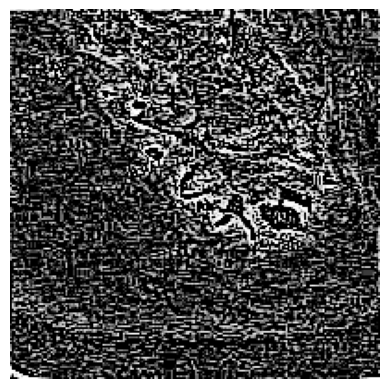

Para el índice 11: 
 El Tipo predicho es: 2 
 El Tipo real es: 2


In [28]:
plt.imshow(x_data[sample.index[0]], "gray"), plt.axis("off")
plt.show()

print("Para el índice {}: \n El Tipo predicho es: {} \n El Tipo real es: {}".format(sample.index[0], sample_predict[0], Y_sel[sample.index[0]]))

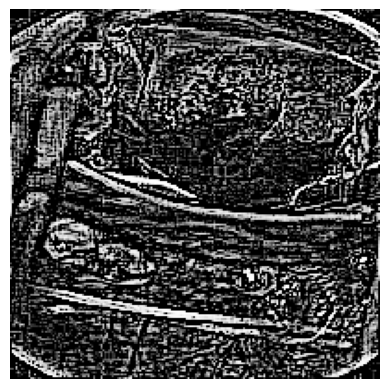

Para el índice 12: 
 El Tipo predicho es: 2 
 El Tipo real es: 1


In [29]:
plt.imshow(x_data[sample.index[1]], "gray"), plt.axis("off")
plt.show()

print("Para el índice {}: \n El Tipo predicho es: {} \n El Tipo real es: {}".format(sample.index[1], sample_predict[1], y_st[sample.index[1]]))

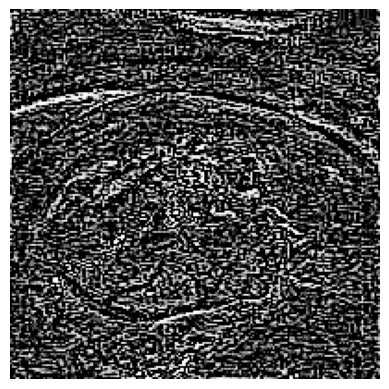

Para el índice 4: 
 El Tipo predicho es: 1 
 El Tipo real es: 1


In [30]:
plt.imshow(x_data[sample.index[2]], "gray"), plt.axis("off")
plt.show()

print("Para el índice {}: \n El Tipo predicho es: {} \n El Tipo real es: {}".format(sample.index[2], sample_predict[2], y_st[sample.index[2]]))

### 
<hr>

Creado por **Javier Gil** (javier.gil.rodriguez@alumnos.upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">